# YT 2020: INDEXER Testing

Перепроверить расчеты можно тут https://yt.yandex-team.ru/hahn/resource-planner/ 

In [1]:
import sys, os, re, logging
from pathlib import Path
import pandas as pd
import numpy as np
from pprint import pformat

%matplotlib inline

cwd = os.getcwd()
preorder_key = max(re.findall(r"(preorder/v\d+apr)", cwd))
capacity_path = Path(cwd[:cwd.rfind(preorder_key)])
sys.path.extend([str(capacity_path),
                 str(capacity_path / preorder_key),
                 str(capacity_path / ("../" * 4))])

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
import warnings
warnings.simplefilter("ignore", UserWarning)

In [4]:
from market.sre.tools.capacity.lib.YT.Cluster import Cluster
from market.sre.tools.capacity.lib.tools import today
from market.sre.tools.capacity.preorder.v2020apr.preorder_lib.core.predictor import Formula, Feature, FormulaStrategy, Predictor, Window
from market.sre.tools.capacity.preorder.v2020apr.input_data.forecast_options import forecast_end_date
from market.sre.tools.capacity.preorder.v2020apr.input_data.YT_accounts import arnold_accounts, hahn_accounts, seneca_sas_accounts, seneca_man_accounts, seneca_vla_accounts
from market.sre.tools.capacity.preorder.v2020apr.input_data.YT_pools import hahn_pools_list, hahn_pools_dict, arnold_pools_list, arnold_pools_dict
from market.sre.tools.capacity.preorder.v2020apr.additional.YT.disk_forecaster import get_disk_forecast
from market.sre.tools.capacity.preorder.v2020apr.additional.YT.cpu_forecaster import get_cpu_forecast
from market.sre.tools.capacity.preorder.v2020apr.preorder_lib.yt.yt_order import YTOrderRequestFile, YTOrderRequestFileItem, YtOrderRequestFileItemDiskQuota, YtOrderRequestFileItemCpuQuota, YtOrderRequestFileItemDTQuota
from market.sre.tools.capacity.preorder.v2020apr.preorder_lib.core.types.department import Department
from market.sre.tools.capacity.preorder.v2020apr.preorder_lib.core.department_info import DepartmentInfo
from market.sre.tools.capacity.preorder.v2020apr.preorder_lib.core.types.cloud import Cloud
from market.sre.tools.capacity.preorder.v2020apr.preorder_lib.core.types.reason import Reason
from market.sre.tools.capacity.preorder.v2020apr.preorder_lib.core.types.deadline import Deadline
from market.sre.tools.capacity.preorder.v2020apr.preorder_lib.core.types.platform import Platform
from market.sre.tools.capacity.preorder.v2020apr.preorder_lib.core.resources_info import ResourcesInfo
from market.sre.tools.capacity.preorder.v2020apr.additional.YT.tools import clean_YT_account

## Настройки

In [5]:
# откуда смотреть историю потребления
date_start = today(minus_days=365, astype=str)
date_end = today(minus_days=1, astype=str)

# учитывать ли пики в пуле?
consider_peaks = False

# verbose
verbose = True

# grid
grid=True

tail_depth = 7
quantile = .8

# formula
formula = None

# formula stratery
formula_strategy = FormulaStrategy.FIRST

# настройки Predictor'а
decreasing_base_function = 'mean'
decreasing_reserve = 2
features = [Feature.OFFERS_COUNT]

# defaults
default_platform = Platform.INFRA
default_department = Department.INDEXER

In [6]:
notebook_filename = f"https://a.yandex-team.ru/arc/trunk/arcadia/market/sre/tools/capacity/{preorder_key}/additional/YT/calculations/indexer_testing.ipynb"
notebook_filename

'https://a.yandex-team.ru/arc/trunk/arcadia/market/sre/tools/capacity/preorder/v2020apr/additional/YT/calculations/indexer_testing.ipynb'

In [7]:
whois = ResourcesInfo(capacity_path / preorder_key / "input_data/files/whois", default_platform=default_platform, default_department=default_department)

In [8]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['grid.color'] = 'k'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 100

grid = True

In [9]:
predictor = Predictor()

### Env

In [10]:
# тестинг это все кроме прода
env = 'production'

## Disk

#### Accounts

In [11]:
label = 'indexer'

_hahn_accounts = [account for account in hahn_accounts if label in account and account not in [account for account in hahn_accounts if label in account and env in account]]
_arnold_accounts = [account for account in arnold_accounts if label in account and account not in [account for account in arnold_accounts if label in account and env in account]]
_seneca_sas_accounts = [account for account in seneca_sas_accounts if label in account and account not in [account for account in seneca_sas_accounts if label in account and env in account]]
_seneca_man_accounts = [account for account in seneca_man_accounts if label in account and account not in [account for account in seneca_man_accounts if label in account and env in account]]
_seneca_vla_accounts = [account for account in seneca_vla_accounts if label in account and account not in [account for account in seneca_vla_accounts if label in account and env in account]]

cluster_accounts = {
    Cluster.HAHN: _hahn_accounts,
    Cluster.ARNOLD: _arnold_accounts,
    Cluster.SENECA_SAS: _seneca_sas_accounts,
    Cluster.SENECA_MAN: _seneca_man_accounts,
    Cluster.SENECA_VLA: _seneca_vla_accounts,
    
}

print(cluster_accounts)

{<Cluster.HAHN: 'hahn'>: ['market-indexer-development', 'market-indexer-testing'], <Cluster.ARNOLD: 'arnold'>: ['market-indexer-development', 'market-indexer-testing', 'market-red-indexer-testing'], <Cluster.SENECA_SAS: 'seneca-sas'>: ['market-indexer-testing'], <Cluster.SENECA_MAN: 'seneca-man'>: [], <Cluster.SENECA_VLA: 'seneca-vla'>: ['market-indexer-testing']}


##### Disk usage history and forecast, GB

HAHN DEFAULT usage: 42112 / 61440 Gb = 68.54 %


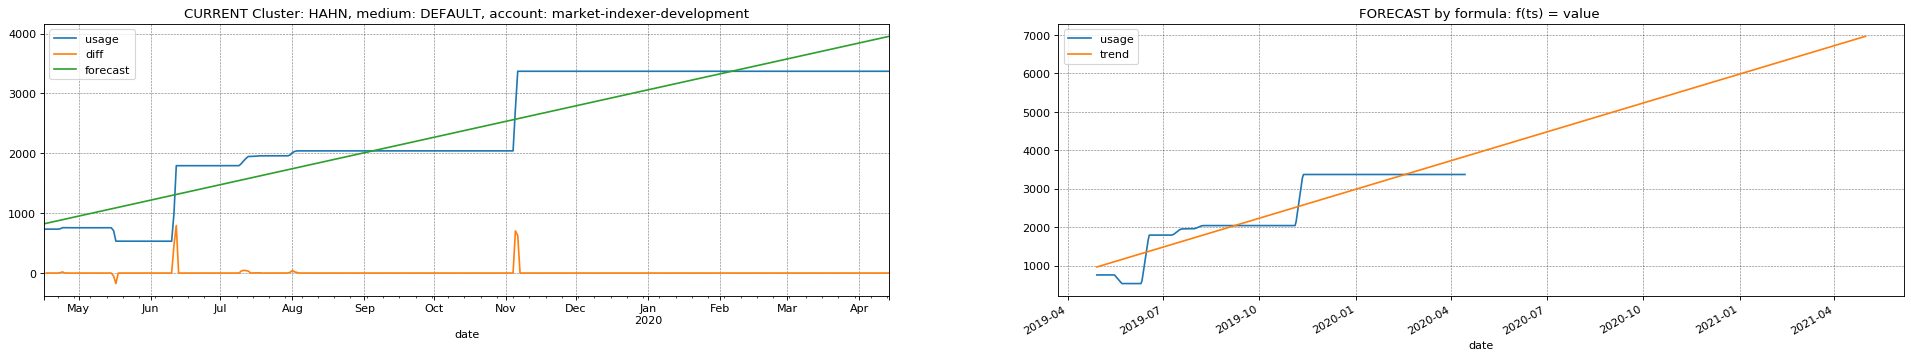

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: -0.24292523997674215,
 <Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: 0.11393957481094111}


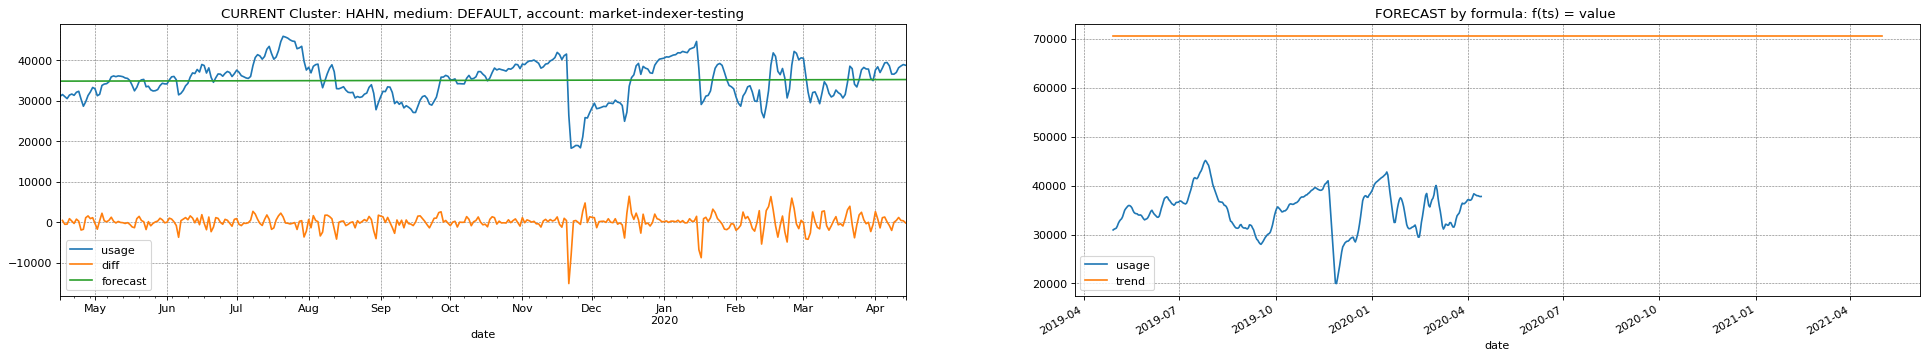

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: -0.21478687822821912,
 <Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: -0.11697891141339468}


HAHN SSD usage: 6211 / 20470 Gb = 30.34 %


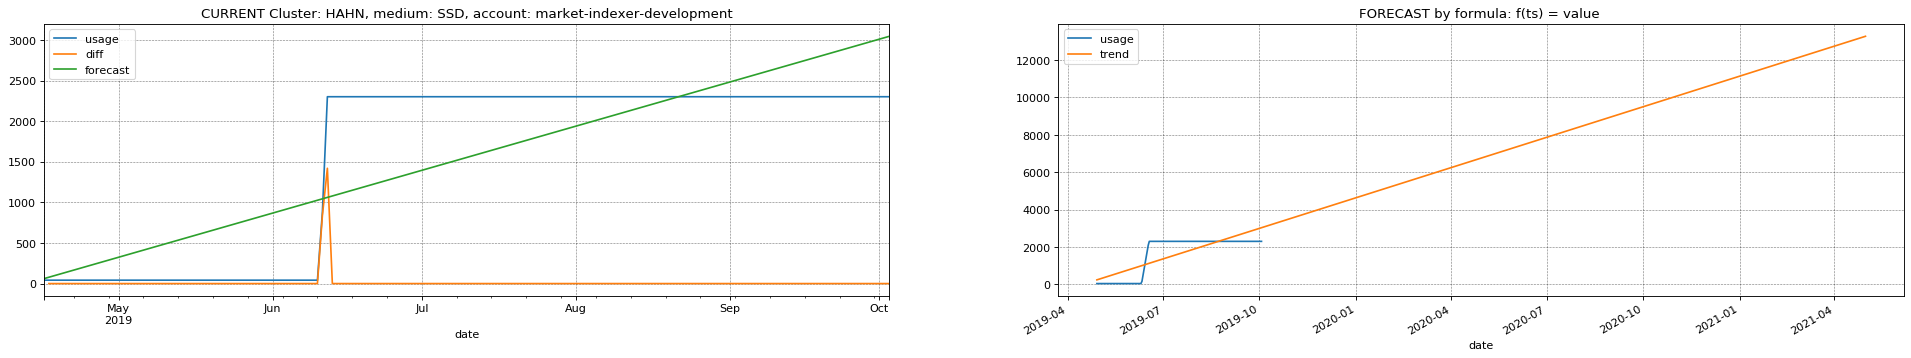

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.05977282194820446,
 <Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: 0.1933661842577754}


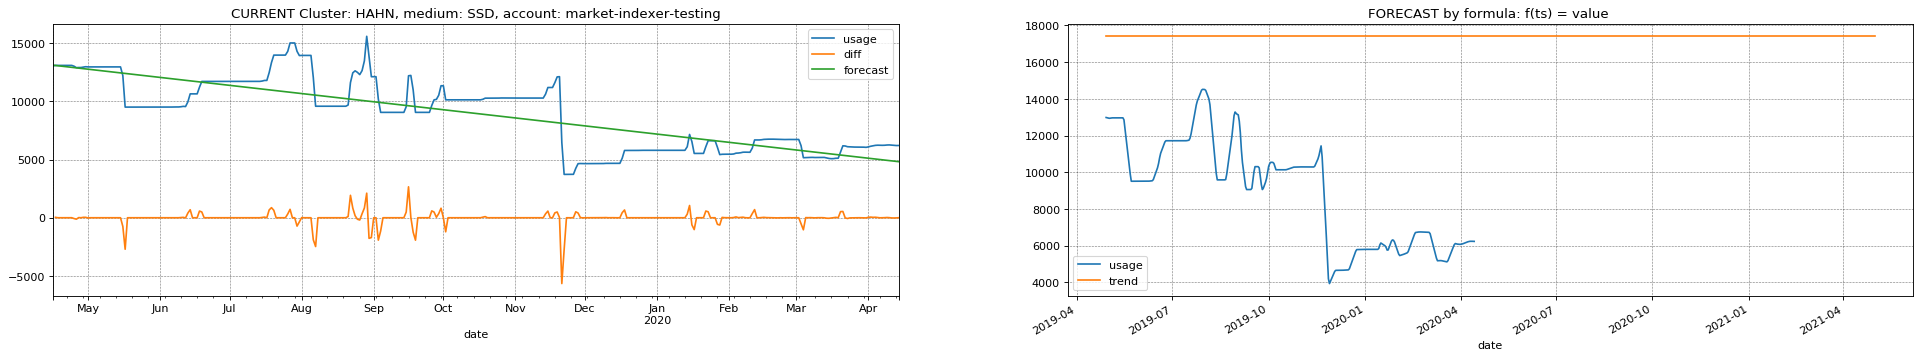

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.230175927244889,
 <Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: -0.06084032020161895}


ARNOLD DEFAULT usage: 55579 / 85607 Gb = 64.92 %


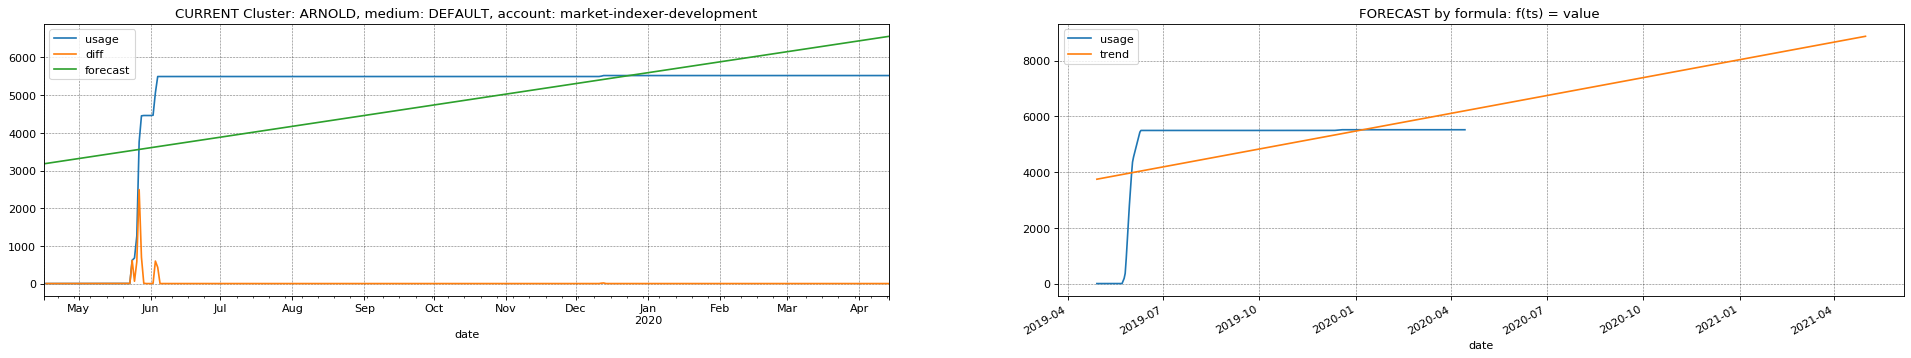

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.008101351131379171,
 <Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: 0.11752161530309514}


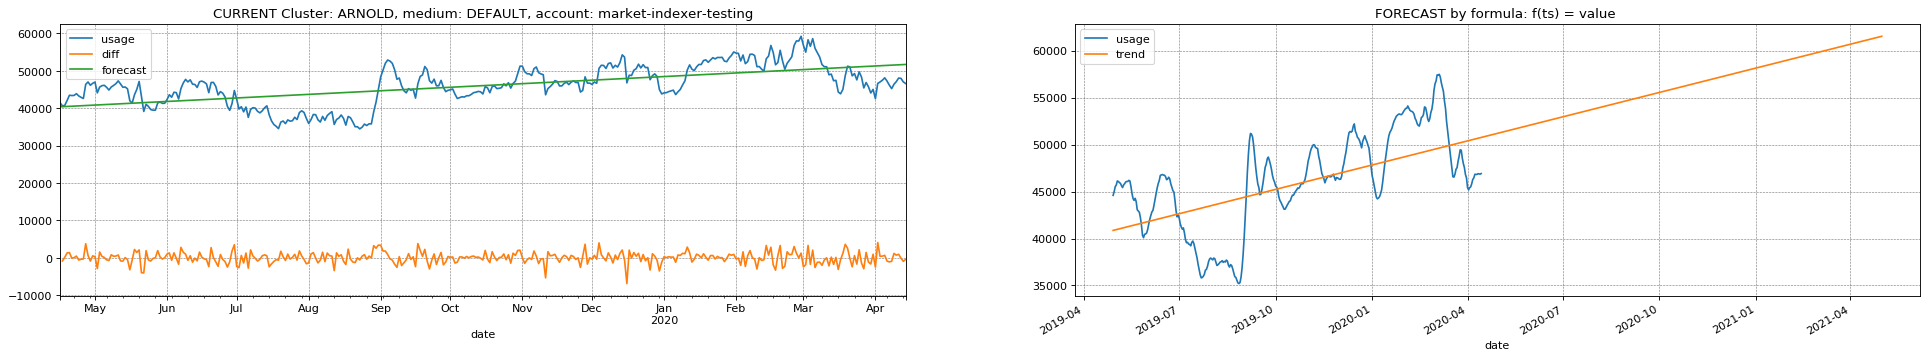

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.015694993125912646,
 <Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: -0.007090898139169725}


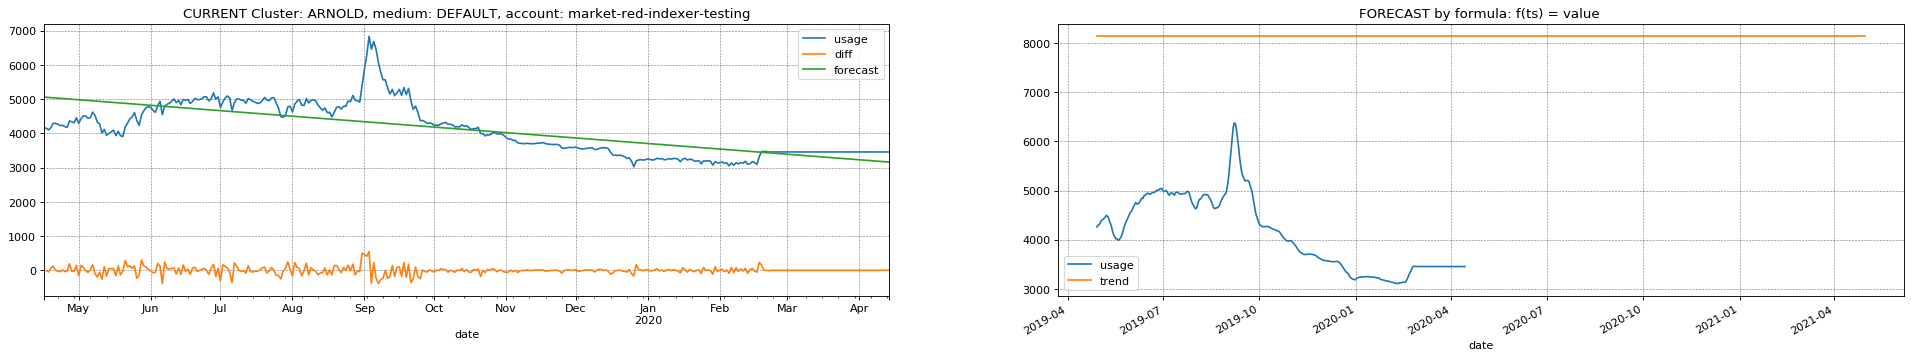

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.22571110730107505,
 <Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: -0.004400800223036726}


ARNOLD SSD usage: 5981 / 24157 Gb = 24.76 %


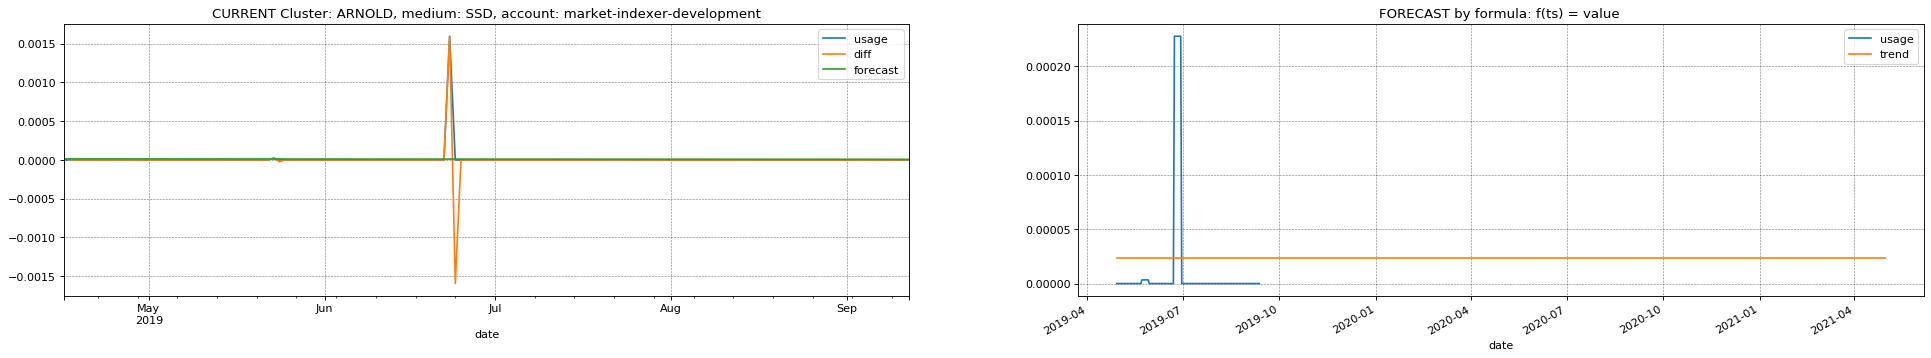

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.16726089416062076,
 <Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: -0.018455954554155787}


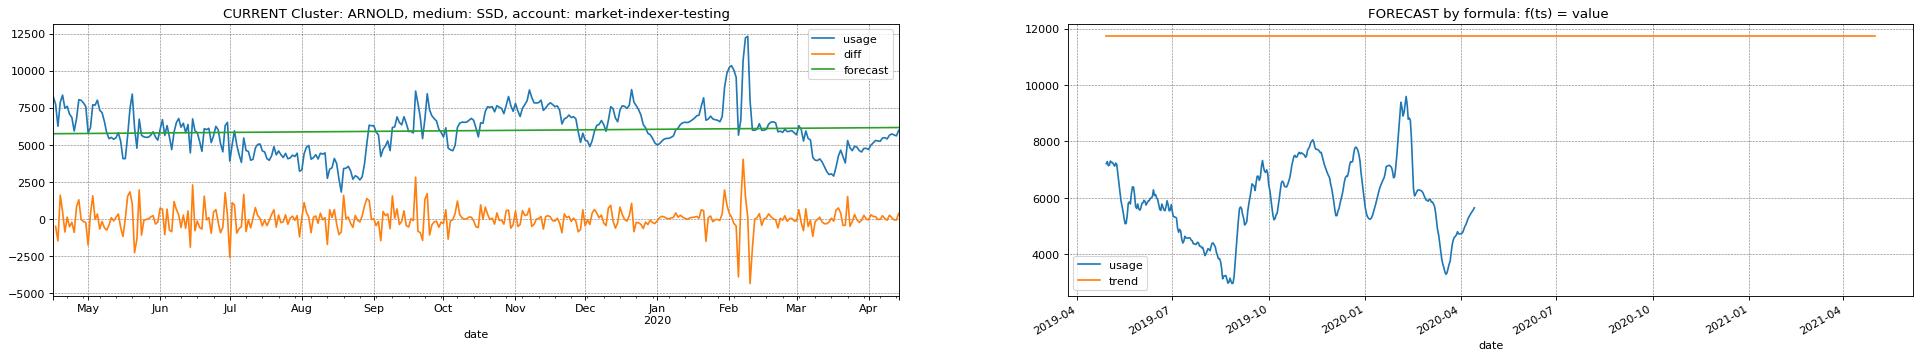

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.13470940830852973,
 <Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: -0.05879787093311016}


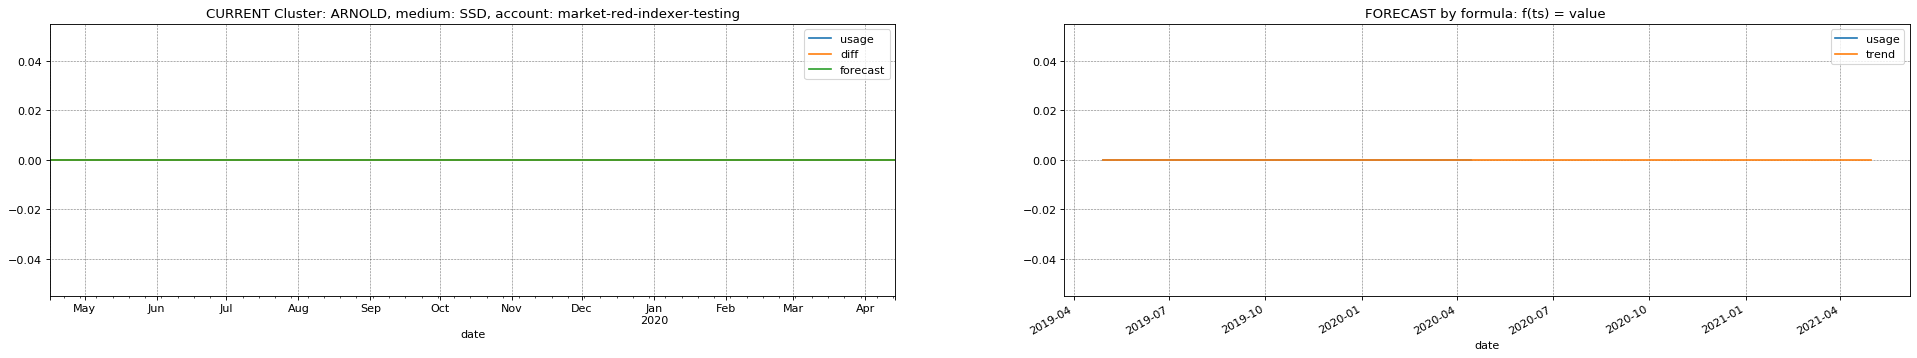

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: nan,
 <Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: nan}


SENECA_SAS DEFAULT usage: 9 / 1024 Gb = 0.88 %


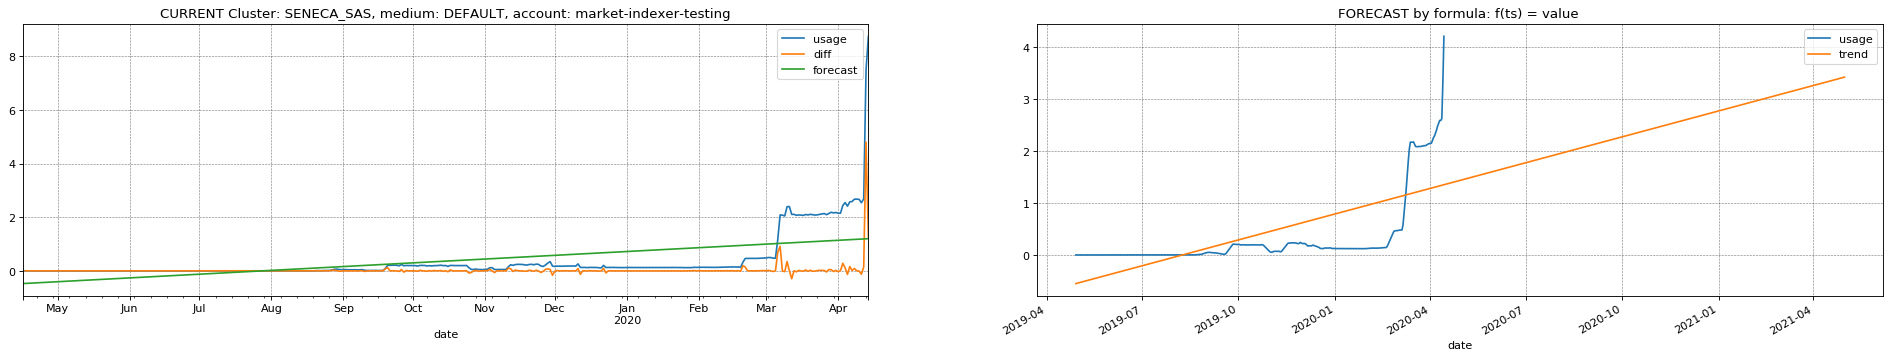

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: -0.48253568119485934,
 <Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: -0.3110064407938763}


SENECA_SAS SSD usage: 237 / 1174 Gb = 20.19 %


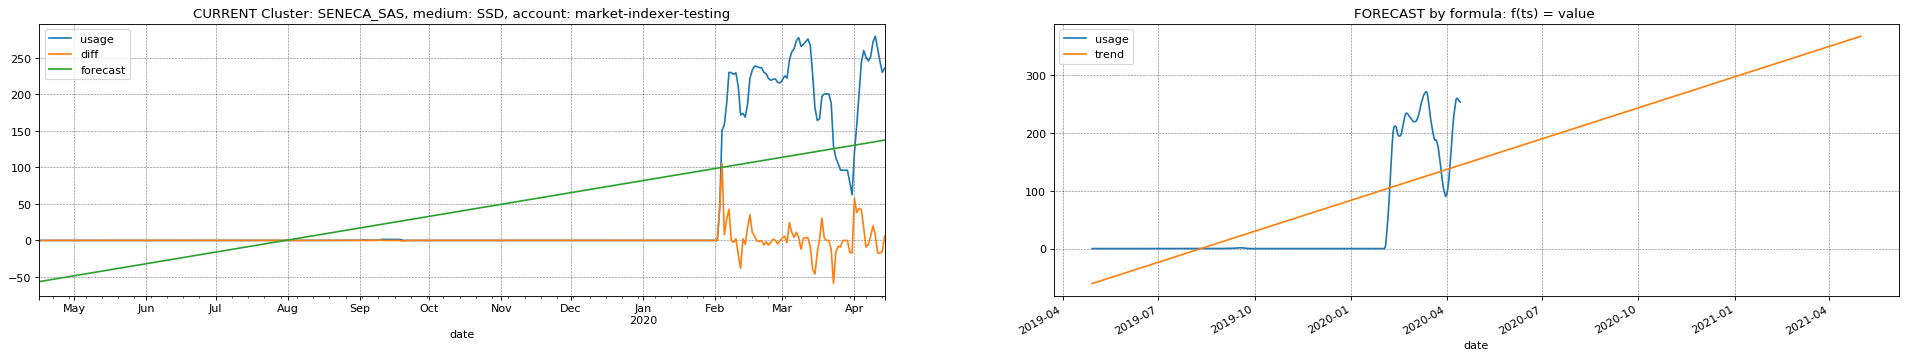

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: -0.2609772089069892,
 <Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: -0.23765020554569743}


SENECA_VLA DEFAULT usage: 15 / 1024 Gb = 1.46 %


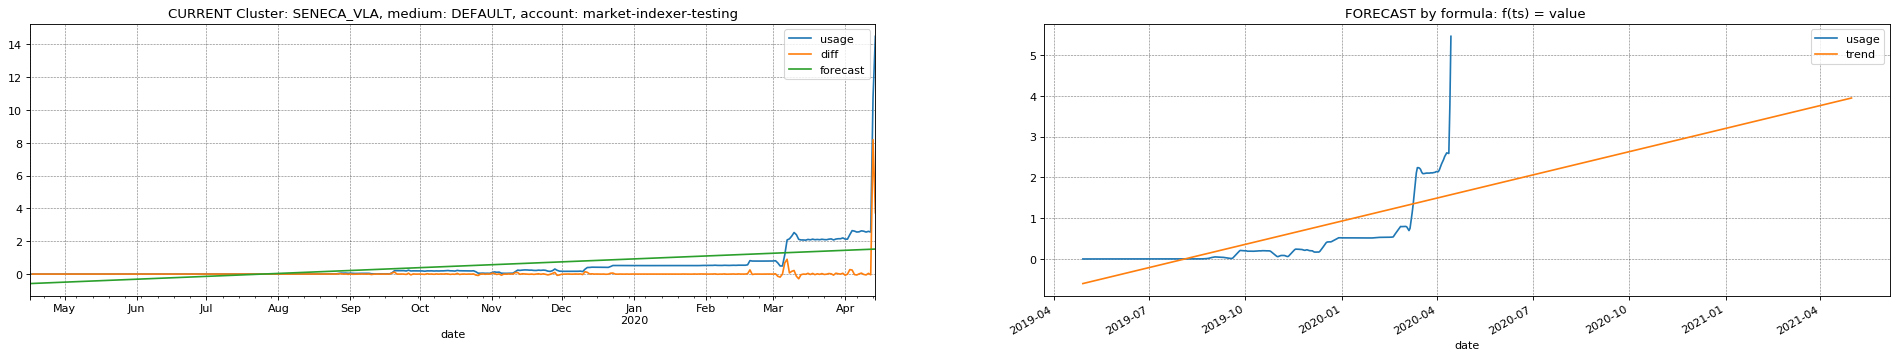

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: -0.5086246241589532,
 <Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: -0.3071878426671285}


SENECA_VLA SSD usage: 236 / 1174 Gb = 20.1 %


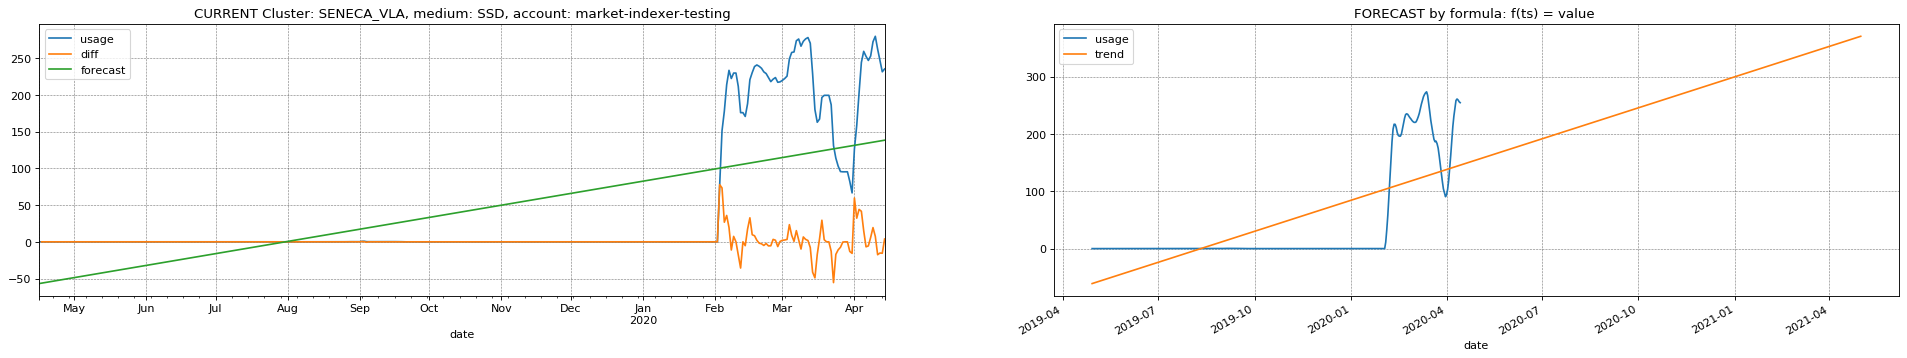

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: -0.26003563696432574,
 <Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: -0.23466405153025718}


In [12]:
disk_forecast = get_disk_forecast(predictor=predictor,
                                  formula=formula,
                                  formula_strategy=formula_strategy,
                                  features=features,
                                  window=Window(),
                                  decreasing_base_function=decreasing_base_function,
                                  decreasing_reserve=decreasing_reserve,
                                  cluster_accounts=cluster_accounts,
                                  date_start=date_start,
                                  date_end=date_end,
                                  verbose=verbose,
                                  grid=grid)

In [13]:
disk_forecast_df = pd.DataFrame(disk_forecast).set_index(['cluster', 'account', 'medium'])
disk_forecast_df

predicted_usage_gb      reason  \
cluster    account                    medium                                    
HAHN       market-indexer-development DEFAULT                6968  CUMULATIVE   
           market-indexer-testing     DEFAULT               70489  CUMULATIVE   
           market-indexer-development SSD                   13273  CUMULATIVE   
           market-indexer-testing     SSD                   17411  CUMULATIVE   
ARNOLD     market-indexer-development DEFAULT                8874  CUMULATIVE   
           market-indexer-testing     DEFAULT               61541  CUMULATIVE   
           market-red-indexer-testing DEFAULT                8141  CUMULATIVE   
           market-indexer-development SSD                       1  CUMULATIVE   
           market-indexer-testing     SSD                   11731  CUMULATIVE   
           market-red-indexer-testing SSD                       0  CUMULATIVE   
SENECA_SAS market-indexer-testing     DEFAULT                   4  CUMULATIVE   
                                      SSD                     368  CUMULATIVE   
SENECA_VLA market-indexer-testing     DEFAULT                   4  CUMULATIVE   
                                      SSD                     371  CUMULATIVE   

                                               usage_gb  quota_gb  
cluster    account                    medium                       
HAHN       market-indexer-development DEFAULT      3371     10240  
           market-indexer-testing     DEFAULT     38742     51200  
           market-indexer-development SSD          2301         0  
           market-indexer-testing     SSD          6211     20470  
ARNOLD     market-indexer-development DEFAULT      5521     10240  
           market-indexer-testing     DEFAULT     46604     69632  
           market-red-indexer-testing DEFAULT      3455      5735  
           market-indexer-development SSD             0         0  
           market-indexer-testing     SSD          5981     20470  
           market-red-indexer-testing SSD             0      3687  
SENECA_SAS market-indexer-testing     DEFAULT         9      1024  
                                      SSD           237      1174  
SENECA_VLA market-indexer-testing     DEFAULT        15      1024  
                                      SSD           236      1174

In [14]:
# for key, value in disk_forecast_df.query("predicted_usage_gb > 0").iterrows():
for key, value in disk_forecast_df.iterrows():
    cluster, account, medium = key
    predicted_usage_gb = value.predicted_usage_gb
    quota_gb = value.quota_gb
    usage_gb = value.usage_gb
    reason = value.reason
    
    if medium == 'DEFAULT':
        disk_quota=YtOrderRequestFileItemDiskQuota(
            accounts=[account],
            hdd_quota_gb=quota_gb,
            hdd_usage_gb=usage_gb,
            predicted_hdd_usage_gb=predicted_usage_gb if 'SENECA' in cluster else int(disk_forecast_df.query(f"account == '{account}' & medium == '{medium}'").max()['predicted_usage_gb']),
        )
    elif medium == 'SSD':
        disk_quota=YtOrderRequestFileItemDiskQuota(
            accounts=[account],
            ssd_quota_gb=quota_gb,
            ssd_usage_gb=usage_gb,
            # https://st.yandex-team.ru/MARKETPREORDER-6
            predicted_ssd_usage_gb=predicted_usage_gb if 'SENECA' in cluster else int(disk_forecast_df.query(f"account == '{account}' & medium == '{medium}'").max()['predicted_usage_gb']),
#             predicted_ssd_usage_gb=predicted_usage_gb
        )
    else:
        raise
    
    resource_info = whois.get_info(Cloud.YT, clean_YT_account(account))
    department_info = DepartmentInfo.from_file(capacity_path / preorder_key / 'input_data/orders', resource_info['department'])
    file_item = YTOrderRequestFileItem(cluster=Cluster.from_str(cluster), 
                                       dc=Cluster.from_str(cluster).get_dc(), 
                                       disk_quota=disk_quota)
    
    YTOrderRequestFile(
        department=resource_info['department'],
        cloud=Cloud.YT,
        platform=resource_info['platform'],
        ticket=notebook_filename,
        contacts=department_info.owners if department_info else [],
        deadline=Deadline.EVENLY,
        items=[file_item],
        file_path=str(capacity_path / preorder_key / (f"input_data/orders/{resource_info['department']}/{Cloud.YT}/disk-{cluster}-{account}-{medium}.yaml")),
        reason=Reason.from_str(reason),
        generated=True).dump_to_file()

### CPU

In [15]:
label = 'indexer'

_hahn_pools_list = [pool for pool in hahn_pools_list if label in pool and env in pool]
_arnold_pools_list = [pool for pool in arnold_pools_list if label in pool and env in pool]

cluster_pools = {
#     Cluster.HAHN: _hahn_pools_list,
    Cluster.HAHN: ['market-testing-indexer'],
#     Cluster.ARNOLD: _arnold_pools_list
    Cluster.ARNOLD: ['market-testing-indexer'],
}

print(cluster_pools)

{<Cluster.HAHN: 'hahn'>: ['market-testing-indexer'], <Cluster.ARNOLD: 'arnold'>: ['market-testing-indexer']}


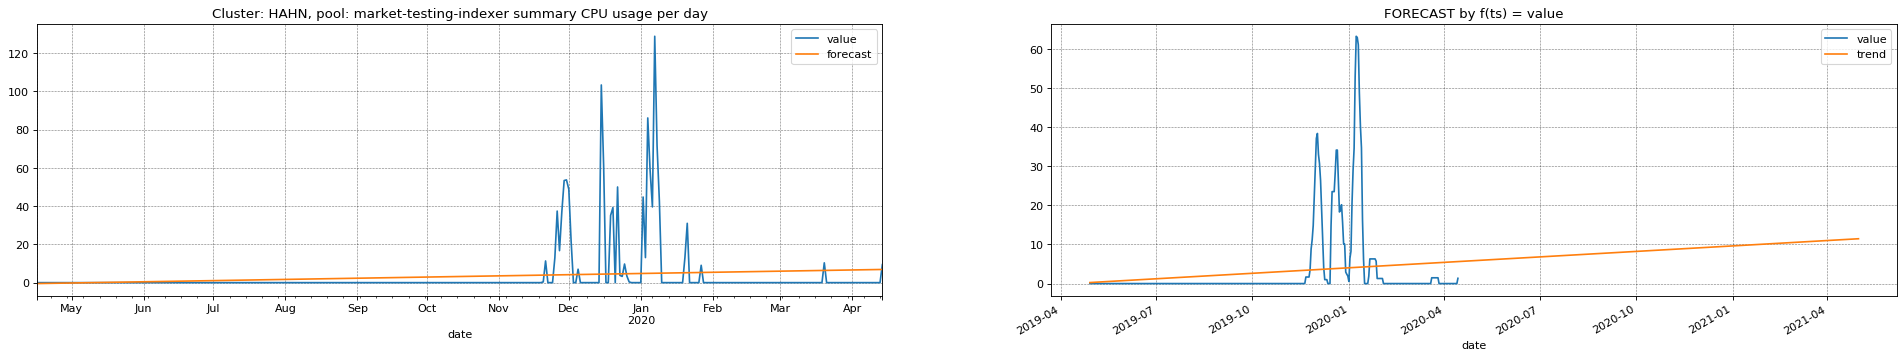

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: -0.2677438812389049,
 <Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: -0.18470606285028207}
Базовый прогноз: 11.46838710054692 ядер


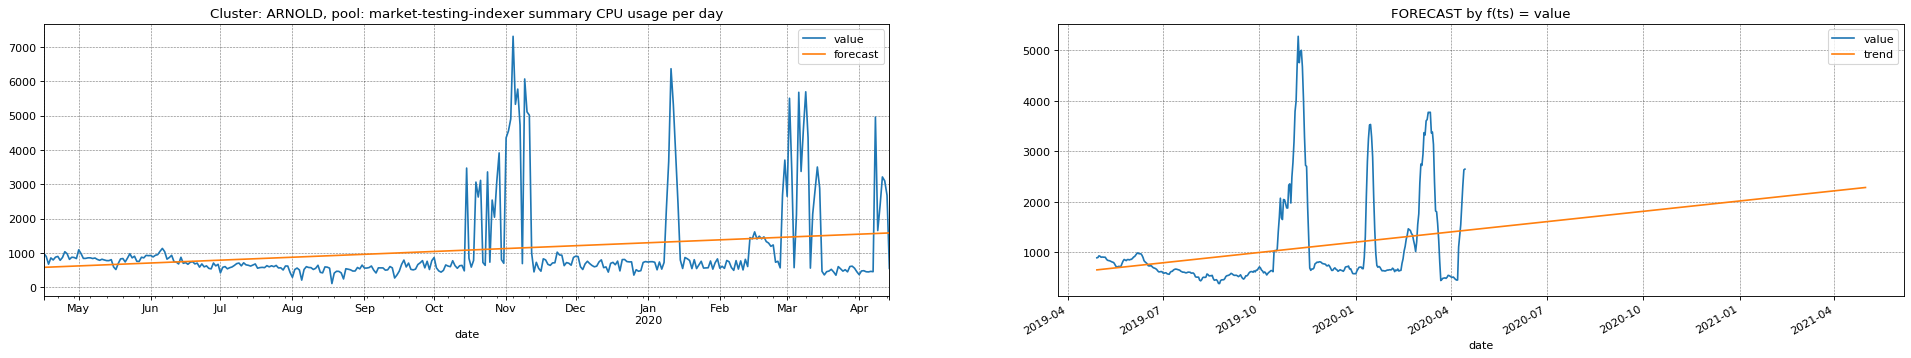

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.04154614825947267,
 <Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: -0.2458610716363124}
Базовый прогноз: 2286.0912804455875 ядер


In [16]:
cpu_forecast = get_cpu_forecast(predictor=predictor,
                                cluster_pools=cluster_pools,
                                formula=formula,
                                formula_strategy=formula_strategy,
                                features=features,
                                window=Window(),
                                decreasing_base_function=decreasing_base_function,
                                decreasing_reserve=decreasing_reserve,
                                consider_peaks=consider_peaks,
                                date_start=date_start,
                                date_end=date_end,
                                peaks_window_1=5,
                                peaks_window_2=60,
                                verbose=verbose,
                                grid=grid,
                                tail_depth=tail_depth,
                                quantile=quantile)

In [17]:
cpu_forecast_df = pd.DataFrame(cpu_forecast).set_index(['cluster', 'pool'])
cpu_forecast_df

,,predicted_usage,reason,peak_coef,usage,quota
cluster,pool,,,,,
HAHN,market-testing-indexer,12,CUMULATIVE,1,0,600
ARNOLD,market-testing-indexer,2287,CUMULATIVE,1,3195,570


In [18]:
# for key, value in cpu_forecast_df.query("predicted_usage > 0").iterrows():
for key, value in cpu_forecast_df.iterrows():
    cluster, pool = key
    predicted_usage = value.predicted_usage
    quota = value.quota
    usage = value.usage
    peak_coef = value.peak_coef
    reason = value.reason
    
    cpu_quota=YtOrderRequestFileItemCpuQuota(
        pools=[pool],
        cpu_quota=quota,
        cpu_usage=usage,
        predicted_cpu_usage=predicted_usage,
        cpu_peak_coef=peak_coef
    )
    
    resource_info = whois.get_info(Cloud.YT, pool)
    department_info = DepartmentInfo.from_file(capacity_path / preorder_key / 'input_data/orders', resource_info['department'])
    file_item = YTOrderRequestFileItem(cluster=Cluster.from_str(cluster), 
                                       dc=Cluster.from_str(cluster).get_dc(), 
                                       cpu_quota=cpu_quota)
    
    YTOrderRequestFile(
        department=resource_info['department'],
        cloud=Cloud.YT,
        platform=resource_info['platform'],
        ticket=notebook_filename,
        contacts=department_info.owners if department_info else [],
        deadline=Deadline.EVENLY,
        items=[file_item],
        file_path=str(capacity_path / preorder_key / (f"input_data/orders/{resource_info['department']}/{Cloud.YT}/pool-{cluster}-{pool}.yaml")),
        reason=Reason.from_str(reason),
        generated=True).dump_to_file()

не забыть про то, что на Хане (пока) тестинга нет